## **DEPARTMENT OF COMPUTER SCIENCE AND TECHNOLOGY**

### **Artificial Intelligence Lab (CS4271)**
### **Name: SAGAR BASAK**
### **Enrollment No: 2021CSB008**
### **Assignment: 3**

## **Question 1**

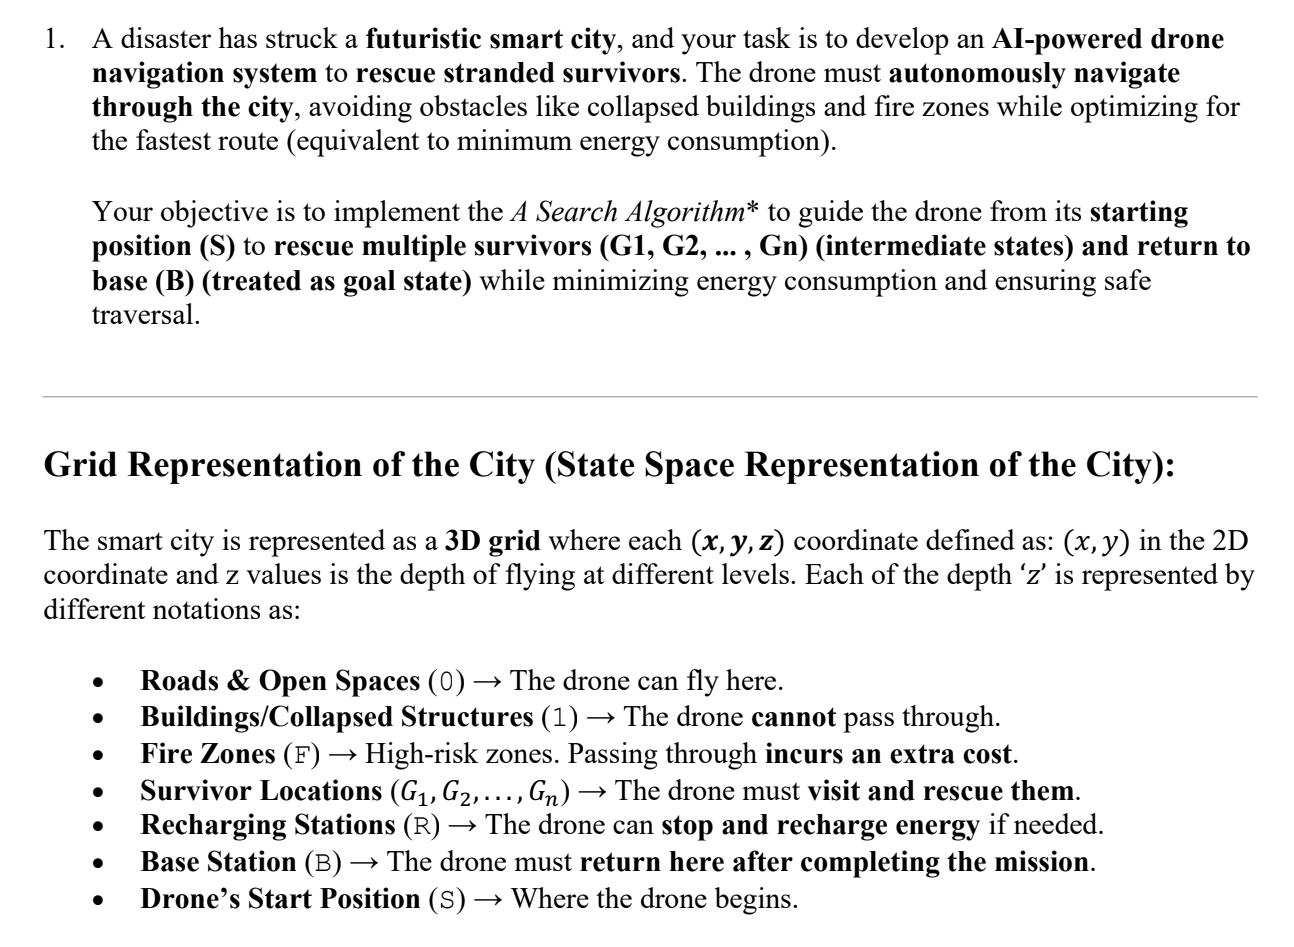

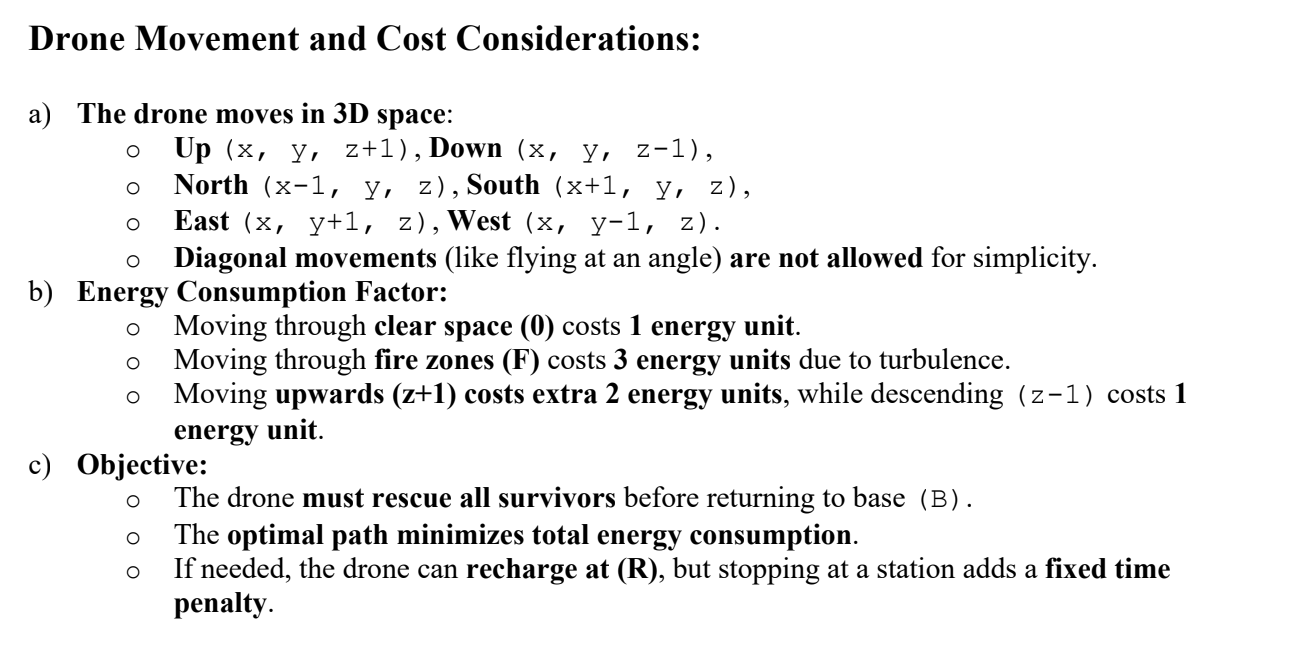

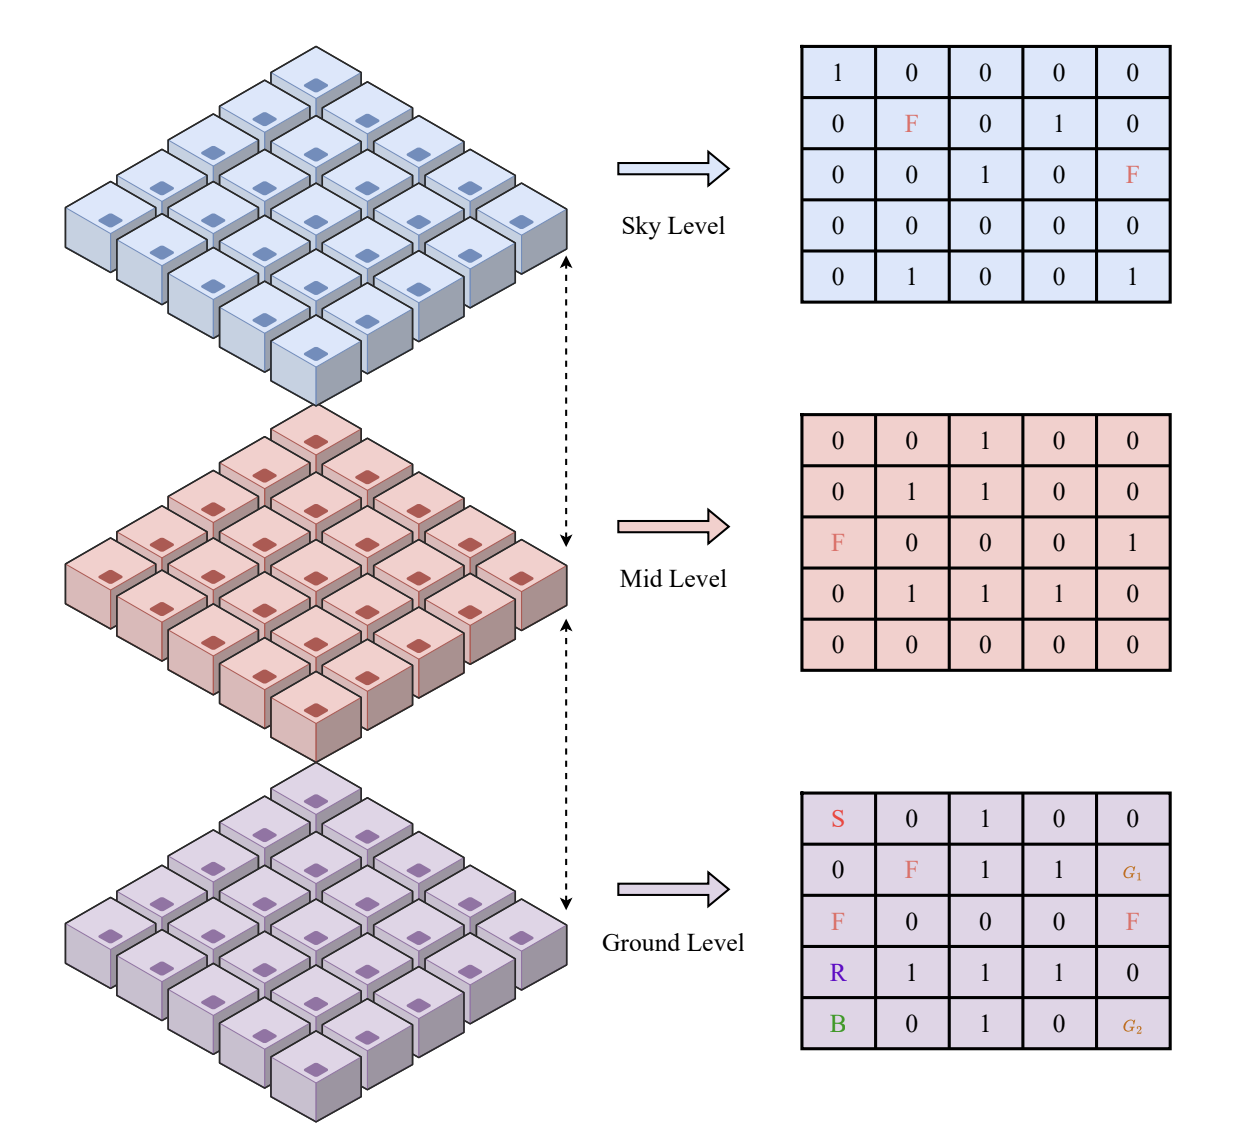

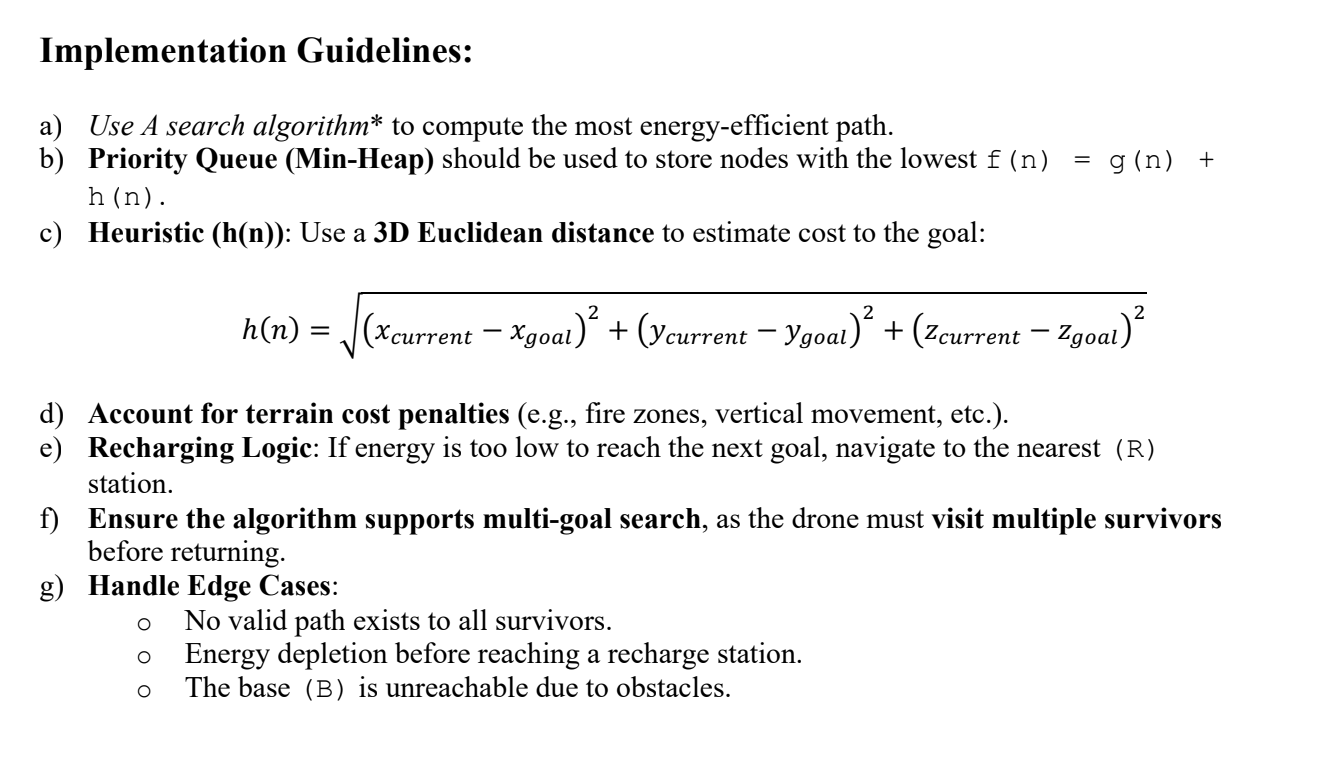

Path found with total cost: 20
Total time taken: 18
Path: [(0, 0, 0), (0, 1, 0), (0, 2, 0), (0, 3, 0), (0, 4, 0), (1, 4, 0), (2, 4, 0), (2, 4, 1), (3, 4, 1), (3, 4, 2), (3, 3, 2), (4, 3, 2), (4, 4, 2), (4, 3, 2), (4, 3, 1), (4, 2, 1), (4, 1, 1), (4, 0, 1), (4, 0, 0)]


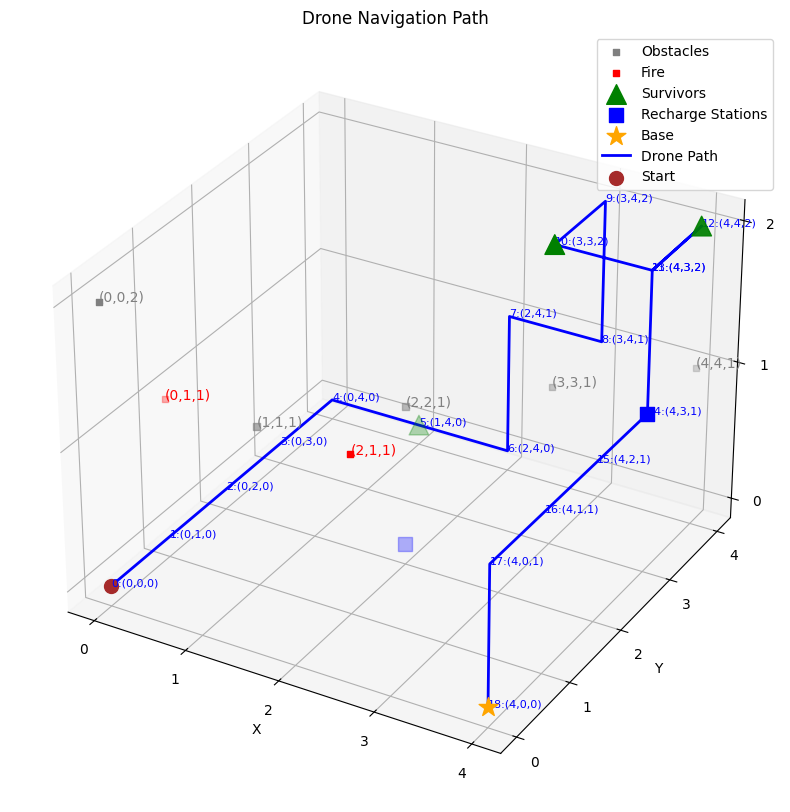

In [33]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Node:
    def __init__(self, pos, g=0, h=0, parent=None, energy=100, time=0):
        self.pos = pos
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent
        self.energy = energy
        self.time = time

    def __lt__(self, other):
        return self.f < other.f

class DroneNavigator:
    def __init__(self, grid, start, survivors, base, recharge_stations, max_energy=100, recharge_penalty=5):
        self.grid = np.array(grid)
        self.start = start
        self.survivors = survivors
        self.base = base
        self.recharge_stations = recharge_stations
        self.shape = self.grid.shape
        self.max_energy = max_energy
        self.recharge_penalty = recharge_penalty

    def is_valid(self, pos):
        x, y, z = pos
        return (0 <= x < self.shape[0] and
                0 <= y < self.shape[1] and
                0 <= z < self.shape[2] and
                self.grid[x,y,z] != 1)

    def get_neighbors(self, pos):
        x, y, z = pos
        moves = [(0,0,1), (0,0,-1), (-1,0,0), (1,0,0), (0,1,0), (0,-1,0)]
        return [(x+dx, y+dy, z+dz) for dx, dy, dz in moves if self.is_valid((x+dx, y+dy, z+dz))]

    def heuristic(self, pos1, pos2):
        return np.sqrt(sum((np.array(pos1) - np.array(pos2)) ** 2))

    def get_path_cost(self, pos1, pos2):
        if self.grid[pos2] == 'F':
            return 3
        elif pos2[2] > pos1[2]:  # Moving up
            return 2
        elif pos2[2] < pos1[2]:  # Moving down
            return 1
        return 1

    def a_star(self, start, goal):
        start_node = Node(start, energy=self.max_energy, time=0)
        open_list = [start_node]
        closed_set = set()

        while open_list:
            current = heapq.heappop(open_list)

            if current.pos == goal:
                path = []
                cost = current.g
                time = current.time
                while current:
                    path.append(current.pos)
                    current = current.parent
                return path[::-1], cost, time

            closed_set.add(current.pos)

            for next_pos in self.get_neighbors(current.pos):
                if next_pos in closed_set:
                    continue

                cost = self.get_path_cost(current.pos, next_pos)
                next_g = current.g + cost
                next_h = self.heuristic(next_pos, goal)
                next_energy = current.energy - cost
                next_time = current.time + 1  # Each move takes 1 unit of time

                if next_energy <= 0:
                    nearest_recharge = min(self.recharge_stations, key=lambda r: self.heuristic(next_pos, r))
                    recharge_path, recharge_cost, recharge_time = self.a_star(current.pos, nearest_recharge)
                    if recharge_path:
                        next_g += recharge_cost
                        next_energy = self.max_energy - cost
                        next_time += recharge_time + self.recharge_penalty
                    else:
                        continue

                next_node = Node(next_pos, next_g, next_h, current, next_energy, next_time)
                heapq.heappush(open_list, next_node)

        return None, float('inf'), float('inf')

    def find_complete_path(self):
        current = self.start
        total_path = [current]
        total_cost = 0
        total_time = 0
        remaining = self.survivors.copy()

        while remaining:
            min_cost = float('inf')
            best_path = None
            best_survivor = None
            best_time = float('inf')

            for survivor in remaining:
                path, cost, time = self.a_star(current, survivor)
                if path and cost < min_cost:
                    min_cost = cost
                    best_path = path
                    best_survivor = survivor
                    best_time = time

            if not best_path:
                print("No valid path to remaining survivors")
                return None, None, None

            total_path.extend(best_path[1:])
            total_cost += min_cost
            total_time += best_time
            current = best_survivor
            remaining.remove(best_survivor)

        base_path, base_cost, base_time = self.a_star(current, self.base)
        if not base_path:
            print("No valid path to base")
            return None, None, None

        total_path.extend(base_path[1:])
        total_cost += base_cost
        total_time += base_time

        return total_path, total_cost, total_time

    def visualize_path(self, path=None):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.set_xticks(range(self.shape[0]))
        ax.set_yticks(range(self.shape[1]))
        ax.set_zticks(range(self.shape[2]))

        x, y, z = np.where(self.grid == 1)
        ax.scatter(x, y, z, c='gray', marker='s', label='Obstacles')
        for obs in zip(x, y, z):
            ax.text(*obs, f'({obs[0]},{obs[1]},{obs[2]})', color='gray')

        x, y, z = np.where(self.grid == 'F')
        ax.scatter(x, y, z, c='red', marker='s', label='Fire')
        for fire in zip(x, y, z):
            ax.text(*fire, f'({fire[0]},{fire[1]},{fire[2]})', color='red')

        surv_x, surv_y, surv_z = zip(*self.survivors)
        ax.scatter(surv_x, surv_y, surv_z, c='green', marker='^', s=200, label='Survivors')

        recharge_x, recharge_y, recharge_z = zip(*self.recharge_stations)
        ax.scatter(recharge_x, recharge_y, recharge_z, c='blue', marker='s', s=100, label='Recharge Stations')

        ax.scatter(*self.base, c='orange', marker='*', s=200, label='Base')

        if path:
            path_x, path_y, path_z = zip(*path)
            ax.plot(path_x, path_y, path_z, c='blue', linewidth=2, label='Drone Path')
            ax.scatter(*self.start, c='brown', marker='o', s=100, label='Start')
            for i, pos in enumerate(path):
                ax.text(*pos, f'{i}:({pos[0]},{pos[1]},{pos[2]})', color='blue', fontsize=8)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.title('Drone Navigation Path')
        plt.show()

# Example usage
grid = np.zeros((5, 5, 3), dtype=object)
obstacles = [(0,0,2), (1,1,1), (2,2,1), (3,3,1), (4,4,1)]
for obs in obstacles:
    grid[obs] = 1
grid[0,1,1] = 'F'
grid[2,1,1] = 'F'

start = (0,0,0)
survivors = [(1,4,0), (3,3,2), (4,4,2)]
base = (4,0,0)
recharge_stations = [(2,2,0), (4,3,1)]

navigator = DroneNavigator(grid, start, survivors, base, recharge_stations, max_energy=100, recharge_penalty=5)
path, cost, time = navigator.find_complete_path()

if path:
    print(f"Path found with total cost: {cost}")
    print(f"Total time taken: {time}")
    print("Path:", path)
    navigator.visualize_path(path)
else:
    print("No valid path found")
